## Objective of the Notebook
(NoobAtem) After downloading all files and collecting the necessary data to our raw folder, were going to proceed trying methods in cleaning the audio. There are standards were going to follow when handling variety of audio source. Known techniques would apply and thus the summary of the notebook is listed
* Resampling
* Segmentation
* Noise Reduction
* Filtering

### Prerequisite Libraries

In [2]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import scipy.signal as signal
import numpy
from pydub import AudioSegment
import os
import yaml
import soundfile as sf
import numpy as np
import pandas as pd
import IPython.display as ipd
import shutil

### Define Relevant Paths

In [4]:
# The main parent folder for handling in all sorts of data
DATA_P: str = "../data"

RAW_P: str = os.path.join(DATA_P, "raw") # Data that we've formatted and designed/collected
EXTERN_P: str = os.path.join(DATA_P, "external") # 3rd party dataset
INTERIM_P: str = os.path.join(DATA_P, "interim") # Dataset that is being process and its under commission
PROCESS_P: str = os.path.join(DATA_P, "processed") # Processed data ready to be used

DOOR_RAW_P: str = os.path.join(RAW_P, "door")
GLASS_RAW_P: str = os.path.join(RAW_P, "glass")
META_RAW_P: str = os.path.join(RAW_P, "metadata.csv")

# The main parent for handling configs
CONFIG_P: str = "../configs"

DATA_CONF_P: str = os.path.join(CONFIG_P, "dataset_config.yaml")
config: dict = None
with open(DATA_CONF_P, "r") as yml_file:
    config = yaml.safe_load(yml_file)

### Testing Transformation

Before applying each methods to our audio, lets first try the method with a single sample. We are going to take a sample from a door sound (Make sure that there is content in raw)

In [9]:
# Get a sample
RAW_DOOR_P: str = os.path.join(RAW_P, "door")
sample_audio: str = os.path.join(RAW_DOOR_P, os.listdir(RAW_DOOR_P)[0])
audio, sr = librosa.load(sample_audio)
librosa.get_duration(y=audio, sr=sr)

5.0

Now, were going to split this audio into 500ms segments using a sliding window technique

In [10]:
window_length: int = int(0.5 * sr) # 500 ms to sample rate
step_size: int = int(0.01 * sr) # The stride

In [11]:
def sliding_window(audio: np.array, length: int, stride: int) -> np.array:
    windows: list = []
    for start in range(0, len(audio) - length + 1, stride):
        windows.append(audio[start: start+length])
    return np.array(windows)

In [47]:
segmented: np.array = sliding_window(audio, window_length, step_size)
count: int = 0
for id in range(len(segmented)):
    count += librosa.get_duration(y= segmented, sr=sr)
count # Total Duration Generated

226.0

To have a better understanding, I'll implement a solution to compute how many audio is generated given a window size

In [50]:
# How many times is stride called with the limit of the length?
count * sr / window_length

452.0

In [58]:
int((len(audio) - window_length + 1) / step_size)

451

Were going to convert it now as a useful function

In [59]:
def number_of_gen_segmneted_audio(audio: np.array, length: int, step: int) -> int:
    return int((len(audio) - length + 1) / size)

Next important tool to use is to have a simple convertion audio file

In [63]:
src: str = f"{EXTERN_P}/Door sounds/Door Opening 1.mp3"
dst: str = f"{EXTERN_P}/Door sounds/Door Opening 1.wav"

In [64]:
sound: object = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

<_io.BufferedRandom name='../data/external/Door sounds/Door Opening 1.wav'>

I will next introduced another technique called padding that will fixed the duration for any thing below that standard

In [101]:
desired_duration: float = 5.0
audio, sr = librosa.load(dst, sr=44100)

In [102]:
# Compute the amount of padding that we need to place
padding_duration: float = desired_duration - librosa.get_duration(y=audio, sr=sr)
padding_length: int = int(padding_duration * sr)
y_pad: np.array = np.pad(audio, (0, padding_length), 'constant')

Will compare it to another to see there is big difference

<Figure size 2000x500 with 0 Axes>

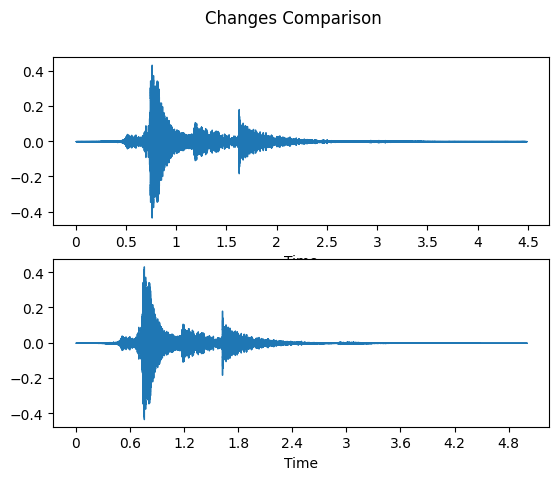

In [103]:
plt.figure(figsize=(20, 5))
fig, ax = plt.subplots(2, sharey=True)
fig.suptitle("Changes Comparison")
librosa.display.waveshow(audio, sr=sr, ax=ax[0])
librosa.display.waveshow(y_pad, sr=sr, ax=ax[1])

How about its spectogram?

<Figure size 2000x500 with 0 Axes>

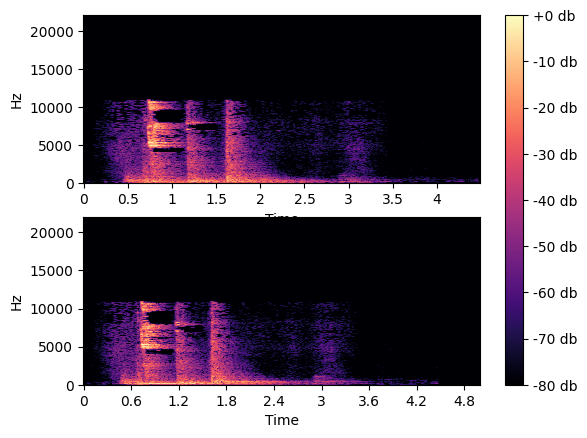

In [114]:
plt.figure(figsize=(20, 5))
fig, ax = plt.subplots(2, sharey=True)
D: np.array = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
img: object = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax[0])
D2: np.array = librosa.amplitude_to_db(np.abs(librosa.stft(y_pad)), ref=np.max)
librosa.display.specshow(D2, y_axis='linear', x_axis='time', sr=sr, ax=ax[1])
fig.colorbar(img, ax=ax, format="%+2.f db")

Pretty much just a slightly shifted spectogram

There are intersting filters we can use to reduce noise. I found interest in trying the basspand filter a go

In [105]:
low_cutoff: int = 50
high_cutoff: int = 16000
nyquist: float = 0.5 * sr
low: float = low_cutoff / nyquist
high: float = high_cutoff / nyquist
print(sr)

44100


In [107]:
b, a = signal.butter(N=4, Wn=[low, high], btype="band")
y_filtered: object = signal.lfilter(b, a, audio)

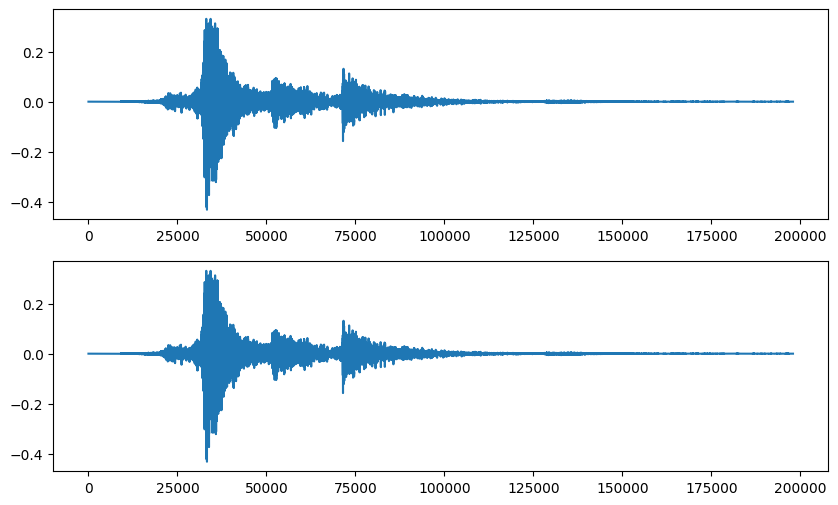

In [115]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(y_filtered)
plt.subplot(2, 1, 2)
plt.plot(y_filtered)
plt.show()

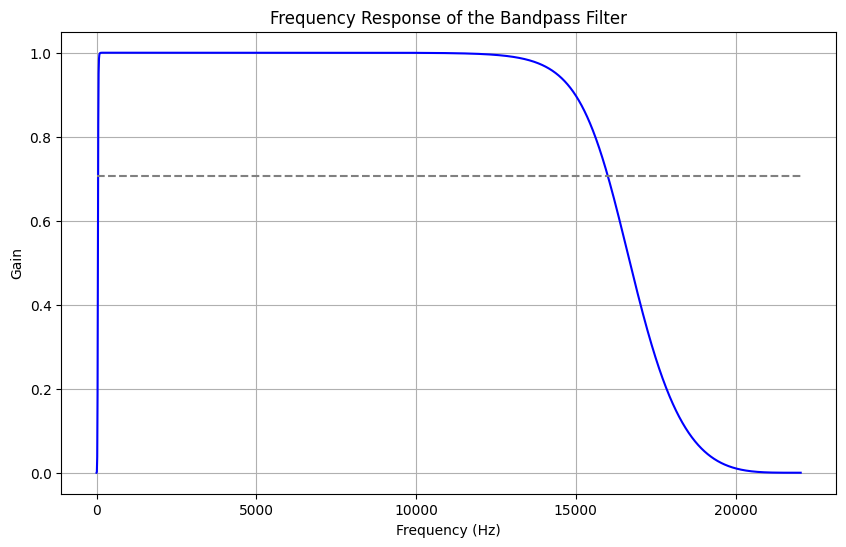

In [116]:
w, h = signal.freqz(b, a, worN=2000)
plt.figure(figsize=(10, 6))
plt.plot(0.5 * sr * w / np.pi, np.abs(h), 'b')
plt.plot([0, 0.5 * sr], [np.sqrt(0.5), np.sqrt(0.5)], '--', color='gray')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency Response of the Bandpass Filter')
plt.grid()
plt.show()

In [118]:
os.remove(dst)

### Apply Techniques 

Were going to first format all of Door sounds by Rion Hermoso, and then pad them after

In [119]:
# Create a folder path
door_sounds_1_p: str = os.path.join(EXTERN_P, "Door sounds")

In [124]:
for mp3 in os.listdir(door_sounds_1_p):
    if mp3.endswith(".mp3"):
        source: str = f"{door_sounds_1_p}/{mp3}"
        output: str = f"{door_sounds_1_p}/{mp3.split('.')[0]}.wav"
        sound: object = AudioSegment.from_mp3(source)
        sound.export(output, format="wav")
        os.remove(source)

Add padding next

In [130]:
for wav in os.listdir(door_sounds_1_p):
    if wav.endswith(".wav"):
        source: str = f"{door_sounds_1_p}/{wav}"
        audio, sr = librosa.load(source, sr=44100)
        desired_duration: float = 5.0
        current_duration: float = librosa.get_duration(y=audio, sr=sr)
        if desired_duration > current_duration:
            padding_duration: float = desired_duration - current_duration
            padding_length: int = int(padding_duration*sr)
            y_padding: np.array = np.pad(audio, (0, padding_length), "constant")
            sf.write(source, y_padding, sr)

If there is durations that are less than the standard, well of course there is one for bigger ones

In [ ]:
files: list = os.listdir(door_sounds_1_p)
for wav in files:
    if wav.endswith(".wav"):
        source: str = f"{door_sounds_1_p}/{wav}"
        audio, sr = librosa.load(source, sr=44100)
        desired_duration: float = 5.0
        if desired_duration < current_duration:
            window_length: int = int(desired_duration * sr)
            step_size: int = int(0.01 * sr)
            segmented: np.array = sliding_window(audio, window_length, step_size)
            for idx in range(len(segmented)):
                _source: str = source.split(".")[0] + "-" + str(idx) + ".wav"
                sf.write(_source, audio, sr)
            os.remove(source)

Found outlier
Found outlier
Found outlier
Found outlier
Found outlier
Found outlier
Found outlier
Found outlier
Found outlier
Found outlier
Found outlier


Manual Download dataset by Hermoso

In [5]:
# Create a path
md_p: str = os.path.join(EXTERN_P, "Manual Download")

In [ ]:
for mp3 in os.listdir(md_p):
    if mp3.endswith(".mp3"):
        source: str = f"{md_p}/{mp3}"
        output: str = f"{md_p}/{mp3.split('.')[0]}.wav"
        sound: object = AudioSegment.from_mp3(source)
        sound.export(output, format="wav")
        os.remove(source)

In [ ]:
for wav in os.listdir(md_p):
    if wav.endswith(".wav"):
        source: str = f"{md_p}/{wav}"
        audio, sr = librosa.load(source, sr=44100)
        desired_duration: float = 5.0
        current_duration: float = librosa.get_duration(y=audio, sr=sr)
        if desired_duration > current_duration:
            padding_duration: float = desired_duration - current_duration
            padding_length: int = int(padding_duration*sr)
            y_padding: np.array = np.pad(audio, (0, padding_length), "constant")
            sf.write(source, y_padding, sr)

In [ ]:
files: list = os.listdir(md_p)
for wav in files:
    if wav.endswith(".wav"):
        source: str = f"{md_p}/{wav}"
        audio, sr = librosa.load(source, sr=44100)
        desired_duration: float = 5.0
        if desired_duration < current_duration:
            window_length: int = int(desired_duration * sr)
            step_size: int = int(0.01 * sr)
            segmented: np.array = sliding_window(audio, window_length, step_size)
            for idx in range(len(segmented)):
                _source: str = source.split(".")[0] + "-" + str(idx) + ".wav"
                sf.write(_source, audio, sr)
            os.remove(source)

### Data Integration to Raw Dataset

Were going to make a function that handles updating meta file in case of new file transfers

In [ ]:
def update_metadata_csv() -> pd.DataFrame:
    df: pd.DataFrame = pd.read_csv(META_RAW_P)

    # Were going to performance a setdiff1D
    door_audio: np.array = np.setdiff1d(os.listdir(DOOR_RAW_P), [".ipynb_checkpoints"])
    glass_audio: np.array = np.setdiff1d(os.listdir(GLASS_RAW_P), [".ipynb_checkpoints"])
    #print(f"Current audio, {door_audio}")
    #print(f"Current audio, {glass_audio}")
    
    # This is to make sure that we dont put the same file into the csv
    door_paths_in_csv: np.array = df[df["category"] == "door_sound"]["filename"].to_numpy()
    glass_paths_in_csv: np.array = df[df["category"] == "glass_breaking"]["filename"].to_numpy()
    #print(f"Current csv, {door_paths_in_csv}")
    #print(f"Current csv, {glass_paths_in_csv}")
    
    # Decide on the difference
    door_audio_missing: list = list(np.setdiff1d(door_audio, door_paths_in_csv))
    glass_audio_missing: list = list(np.setdiff1d(glass_audio, glass_paths_in_csv))
    #print(f"Currently missing wav file, {door_audio_missing}")
    #print(f"Currently missing wav file, {glass_audio_missing}")

    for missing in door_audio_missing:
        # Get the id which is already specified in the filename
        door_id = missing.split(".")[0].split("-")[-1]
        df.loc[len(df.index)] = [door_id, missing, os.path.join(DOOR_RAW_P, missing), "door_sound"]

    for missing in glass_audio_missing:
        # Get the id which is already specified in the filename
        glass_id = missing.split(".")[0].split("-")[-1]
        df.loc[len(df.index)] = [glass_id, missing, os.path.join(GLASS_RAW_P, missing), "glass_breaking"]

    df.to_csv(META_RAW_P, index=False)
    return df

Push to raw folder

In [ ]:
count: int = len(os.listdir(DOOR_RAW_P))
for files in os.listdir(door_sounds_1_p):
    if files.endswith(".wav"):
        count += 1
        destination: str = os.path.join(DOOR_RAW_P, f"door-{count}.wav")
        shutil.copy(os.path.join(door_sounds_1_p, files), destination)

In [ ]:
update_metadata_csv()